In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat, savemat
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from time import time

optimize = True
LED = 123
pixel_well_depth = 20000
numchannel = 1
batch_size = 32

In [2]:
path = "C:/Users/ameyc/Dropbox/Deep Learning Microscope Code/data/thick_smear/raw_data/images_infected_thicksmear_colorcombo.mat"
mal_dict = loadmat(path)
infected = mal_dict['images_infected_thicksmear_colorcombo']
path = "C:/Users/ameyc/Dropbox/Deep Learning Microscope Code/data/thick_smear/raw_data/images_noinfection_thicksmear_colorcombo.mat"
wmal_dict = loadmat(path)
normal = wmal_dict['images_noinfection_thicksmear_colorcombo']
infected = np.moveaxis(infected, -1, 0)
normal = np.moveaxis(normal, -1, 0)

infected_train, infected_test = train_test_split(infected, test_size = 0.2)
normal_train, normal_test = train_test_split(normal, test_size = 0.2)
normal_train.shape

(564, 28, 28, 123)

In [3]:
def add_noise(x):
    noise = tf.random.normal(shape = tf.shape(x))
    noise = noise*tf.math.sqrt(x*(1-1/(n+1)/numchannel)*256/pixel_well_depth)
    x = tf.add(x, noise)
    return x

def np_add_noise(x, n, dtype=tf.float32):
    def _np_add_noise(x, n):
        x += np.random.normal(loc=0, scale=np.sqrt(x*(1-1/(n+1)/numchannel)*256/pixel_well_depth))
        return x
    
    shape = tf.shape(x)
    z = tf.py_func(_np_add_noise, [x, n], dtype)
    z = tf.reshape(z, shape)
    return z
    

In [4]:
def get_training_iterator(n = 0):
    infected_dataset = tf.data.Dataset.from_tensor_slices(infected_test//(n+1))
    normal_dataset = tf.data.Dataset.from_tensor_slices(normal_test//(n+1))
    
    if n > 0:
        infected_dataset = infected_dataset.shuffle(n+1).repeat().batch(1)
        normal_dataset1 = normal_dataset.shuffle(n+1).repeat().batch(n)
        dataset1 = tf.data.Dataset.zip((infected_dataset, normal_dataset1))
        dataset1 = dataset1.map(lambda x,y: (tf.cast(tf.reduce_sum(tf.concat([x, y], axis=0), axis=0), tf.uint8), [0,1]))
        dataset1 = dataset1.map(lambda x, n: np_add_noise(x, n))
        dataset1 = dataset1.batch(16)
    else:
        dataset1 = infected_dataset.repeat().map(lambda x: (tf.cast(x, tf.uint8), [0,1]))
        dataset1 = dataset1.map(lambda x, n: np_add_noise(x, n))
        dataset1 = dataset1.shuffle(17).batch(16)
    
    dataset0 = normal_dataset.shuffle(n+2).repeat().batch(n+1)
    dataset0 = dataset0.map(lambda x: (tf.cast(tf.reduce_sum(x, axis=0), tf.uint8), [1,0]))
    dataset0 = dataset0.map(lambda x, y: np_add_noise(x, n))
    dataset0 = dataset0.batch(16)
    
    iterator0 = dataset0.make_initializable_iterator()
    iterator1 = dataset1.make_initializable_iterator()
    
    return iterator0, iterator1

def get_testing_iterator(n = 0):
    infected_dataset = tf.data.Dataset.from_tensor_slices(infected_test//(n+1))
    normal_dataset = tf.data.Dataset.from_tensor_slices(normal_test//(n+1))
    
    if n > 0:
        infected_dataset = infected_dataset.shuffle(n+1).repeat().batch(1)
        normal_dataset1 = normal_dataset.shuffle(n+1).repeat().batch(n)
        dataset1 = tf.data.Dataset.zip((infected_dataset, normal_dataset1))
        dataset1 = dataset1.map(lambda x,y: (tf.cast(tf.reduce_sum(tf.concat([x, y], axis=0), axis=0), tf.uint8), [0,1]))
        dataset1 = dataset1.map(lambda x, n: np_add_noise(x, n))
        dataset1 = dataset1.batch(16)
    else:
        dataset1 = infected_dataset.repeat().map(lambda x: (tf.cast(x, tf.uint8), [0,1]))
        dataset1 = dataset1.map(lambda x, n: np_add_noise(x, n))
        dataset1 = dataset1.shuffle(17).batch(16)
    
    dataset0 = normal_dataset.shuffle(n+2).repeat().batch(n+1)
    dataset0 = dataset0.map(lambda x: (tf.cast(tf.reduce_sum(x, axis=0), tf.uint8), [1,0]))
    dataset0 = dataset0.map(lambda x, n: np_add_noise(x, n))
    dataset0 = dataset0.batch(16)
    
    iterator0 = dataset0.make_initializable_iterator()
    iterator1 = dataset1.make_initializable_iterator()
    
    return iterator0, iterator1

In [5]:
def get_batch(n, istrain):
    if istrain == 0:
        x0, y0 = train_it0.get_next()
        x1, y1 = train_it1.get_next()
        x = tf.cast(tf.concat([x0,x1], axis=0), tf.float32)
        #x = np_add_noise(x, n)
        y = tf.concat([y0,y1], axis=0)
    else:
        x0, y0 = test_it0.get_next()
        x1, y1 = test_it1.get_next()
        x = tf.cast(tf.concat([x0,x1], axis=0), tf.float32)
        #x = np_add_noise(x, n)
        y = tf.concat([y0,y1], axis=0)     
    return x, y

In [6]:
def pass_through_validation(sess, n = 0, numbatches = 50):
    val = 0
    for i in range(numbatches):
        val += sess.run(accuracy, feed_dict = {train_place: 1})
    return val/numbatches

In [7]:
def CNN2(net,labels,numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.Flatten()(net) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    return net #return net to examine accuracy

In [8]:
def optimize_illumination(images, weights):
    x_added = tf.einsum('aij,jk->aik', images, weights)
#     print('shape after einsum multiplication')
#     print(x_added.get_shape())
    x_added = tf.reshape(x_added, [-1,28,28,1])
    return x_added

In [9]:
acc = list()
weights = list()
fulls = time()
with tf.device('/device:GPU:0'):
    for n in range(15):
        tf.reset_default_graph() 
        sess = tf.Session()
        train_it0, train_it1 = get_training_iterator(n)
        test_it0, test_it1 = get_testing_iterator(n)
        train_place = tf.placeholder(tf.int8)
        images, label = get_batch(n, istrain=train_place)
        if optimize:
#             added_intensity_weights = np.zeros((LED, 1), dtype=np.float32)
#             added_intensity_weights[0] = 1  #This is the center LED for red (second image)
#             added_intensity_weights[41] = 1  #This is the center LED for green (second image)
#             added_intensity_weights[82] = 1  #This is the center LED for blue (second image)
            LED_w = tf.Variable(tf.truncated_normal(shape=[LED,1], stddev=0.1))#tf.constant(added_intensity_weights))
            images = tf.reshape(images, [-1, 784, LED])
            images = optimize_illumination(images, LED_w)
        pred = CNN2(images, label, 2)
        loss = tf.losses.softmax_cross_entropy(logits=pred, onehot_labels=label)
        train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
        prediction = tf.argmax(pred,1)
        truth = tf.argmax(label,1)
        accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction,truth)))

        Accuracy = list()
        epochweights = list()
        for runs in range(10):
            sess.run(tf.global_variables_initializer())
            sess.run(train_it0.initializer)
            sess.run(train_it1.initializer)
            sess.run(test_it0.initializer)
            sess.run(test_it1.initializer)
            train_losses = list()
            val_losses = list()
            start=time()
            for i in range(501):
                _, tloss = sess.run([train_op, loss], feed_dict={train_place: 0})
                train_losses.append(tloss)
                if i%250==0:
                    prediction = list()
                    y_label = list()
                    val_losses.append(pass_through_validation(sess, n, numbatches=20))
                    print("iteration %d; batch classifier loss: %f; batch Validation accuracy: %f; Time passed in this loop: %.2f" % 
                          (i,train_losses[-1],val_losses[-1],time()-start))
            epochweights.append(sess.run(LED_w))
            Accuracy.append(val_losses[-1])
        acc.append(Accuracy)
        weights.append(epochweights)
        sess.close()
fulle = time()

iteration 0; batch classifier loss: 0.651160; batch Validation accuracy: 0.503125; Time passed in this loop: 16.42
iteration 250; batch classifier loss: 0.001580; batch Validation accuracy: 1.000000; Time passed in this loop: 20.67
iteration 500; batch classifier loss: 0.000623; batch Validation accuracy: 1.000000; Time passed in this loop: 24.92
iteration 0; batch classifier loss: 1.205152; batch Validation accuracy: 0.500000; Time passed in this loop: 0.21
iteration 250; batch classifier loss: 0.001378; batch Validation accuracy: 1.000000; Time passed in this loop: 4.52
iteration 500; batch classifier loss: 0.000358; batch Validation accuracy: 1.000000; Time passed in this loop: 8.83
iteration 0; batch classifier loss: 0.923071; batch Validation accuracy: 0.593750; Time passed in this loop: 0.22
iteration 250; batch classifier loss: 0.000970; batch Validation accuracy: 1.000000; Time passed in this loop: 4.54
iteration 500; batch classifier loss: 0.000233; batch Validation accuracy: 

iteration 500; batch classifier loss: 0.171138; batch Validation accuracy: 0.960938; Time passed in this loop: 28.49
iteration 0; batch classifier loss: 0.783440; batch Validation accuracy: 0.500000; Time passed in this loop: 0.95
iteration 250; batch classifier loss: 0.029697; batch Validation accuracy: 0.973437; Time passed in this loop: 14.76
iteration 500; batch classifier loss: 0.020554; batch Validation accuracy: 0.987500; Time passed in this loop: 28.91
iteration 0; batch classifier loss: 0.891332; batch Validation accuracy: 0.496875; Time passed in this loop: 0.95
iteration 250; batch classifier loss: 0.182003; batch Validation accuracy: 0.881250; Time passed in this loop: 14.99
iteration 500; batch classifier loss: 0.328780; batch Validation accuracy: 0.950000; Time passed in this loop: 28.78
iteration 0; batch classifier loss: 0.826300; batch Validation accuracy: 0.500000; Time passed in this loop: 0.97
iteration 250; batch classifier loss: 0.115148; batch Validation accuracy

iteration 250; batch classifier loss: 0.441820; batch Validation accuracy: 0.840625; Time passed in this loop: 21.28
iteration 500; batch classifier loss: 0.078247; batch Validation accuracy: 0.953125; Time passed in this loop: 41.30
iteration 0; batch classifier loss: 1.232878; batch Validation accuracy: 0.500000; Time passed in this loop: 1.44
iteration 250; batch classifier loss: 0.090451; batch Validation accuracy: 0.976562; Time passed in this loop: 22.05
iteration 500; batch classifier loss: 0.035680; batch Validation accuracy: 0.967187; Time passed in this loop: 42.11
iteration 0; batch classifier loss: 1.035179; batch Validation accuracy: 0.500000; Time passed in this loop: 1.43
iteration 250; batch classifier loss: 0.182666; batch Validation accuracy: 0.917188; Time passed in this loop: 21.31
iteration 500; batch classifier loss: 0.194531; batch Validation accuracy: 0.959375; Time passed in this loop: 41.27
iteration 0; batch classifier loss: 0.938923; batch Validation accurac

iteration 0; batch classifier loss: 1.281111; batch Validation accuracy: 0.500000; Time passed in this loop: 2.42
iteration 250; batch classifier loss: 0.551460; batch Validation accuracy: 0.721875; Time passed in this loop: 35.36
iteration 500; batch classifier loss: 0.452182; batch Validation accuracy: 0.828125; Time passed in this loop: 66.27
iteration 0; batch classifier loss: 1.043453; batch Validation accuracy: 0.500000; Time passed in this loop: 2.26
iteration 250; batch classifier loss: 0.515516; batch Validation accuracy: 0.637500; Time passed in this loop: 33.25
iteration 500; batch classifier loss: 0.236005; batch Validation accuracy: 0.875000; Time passed in this loop: 64.94
iteration 0; batch classifier loss: 1.108314; batch Validation accuracy: 0.507812; Time passed in this loop: 2.31
iteration 250; batch classifier loss: 0.600790; batch Validation accuracy: 0.670312; Time passed in this loop: 34.36
iteration 500; batch classifier loss: 0.568196; batch Validation accuracy

iteration 500; batch classifier loss: 0.447819; batch Validation accuracy: 0.806250; Time passed in this loop: 87.79
iteration 0; batch classifier loss: 1.385308; batch Validation accuracy: 0.500000; Time passed in this loop: 3.04
iteration 250; batch classifier loss: 0.456150; batch Validation accuracy: 0.726562; Time passed in this loop: 44.28
iteration 500; batch classifier loss: 0.448592; batch Validation accuracy: 0.823438; Time passed in this loop: 85.82
iteration 0; batch classifier loss: 0.975568; batch Validation accuracy: 0.500000; Time passed in this loop: 3.69
iteration 250; batch classifier loss: 0.412731; batch Validation accuracy: 0.751563; Time passed in this loop: 47.94
iteration 500; batch classifier loss: 0.166613; batch Validation accuracy: 0.865625; Time passed in this loop: 89.84
iteration 0; batch classifier loss: 1.259583; batch Validation accuracy: 0.498437; Time passed in this loop: 3.40
iteration 250; batch classifier loss: 0.585811; batch Validation accuracy

iteration 250; batch classifier loss: 0.571075; batch Validation accuracy: 0.690625; Time passed in this loop: 49.26
iteration 500; batch classifier loss: 0.482420; batch Validation accuracy: 0.706250; Time passed in this loop: 95.22
iteration 0; batch classifier loss: 0.809360; batch Validation accuracy: 0.500000; Time passed in this loop: 3.45
iteration 250; batch classifier loss: 0.681420; batch Validation accuracy: 0.629687; Time passed in this loop: 49.17
iteration 500; batch classifier loss: 0.354228; batch Validation accuracy: 0.856250; Time passed in this loop: 94.81
iteration 0; batch classifier loss: 1.331726; batch Validation accuracy: 0.500000; Time passed in this loop: 6.79
iteration 250; batch classifier loss: 0.595721; batch Validation accuracy: 0.746875; Time passed in this loop: 56.65
iteration 500; batch classifier loss: 0.445714; batch Validation accuracy: 0.784375; Time passed in this loop: 105.78
iteration 0; batch classifier loss: 1.019212; batch Validation accura

iteration 0; batch classifier loss: 1.094943; batch Validation accuracy: 0.500000; Time passed in this loop: 4.15
iteration 250; batch classifier loss: 0.704330; batch Validation accuracy: 0.635938; Time passed in this loop: 59.65
iteration 500; batch classifier loss: 0.526497; batch Validation accuracy: 0.700000; Time passed in this loop: 115.07
iteration 0; batch classifier loss: 1.206072; batch Validation accuracy: 0.500000; Time passed in this loop: 4.15
iteration 250; batch classifier loss: 0.667086; batch Validation accuracy: 0.637500; Time passed in this loop: 59.63
iteration 500; batch classifier loss: 0.478806; batch Validation accuracy: 0.750000; Time passed in this loop: 115.31
iteration 0; batch classifier loss: 0.709605; batch Validation accuracy: 0.500000; Time passed in this loop: 4.14
iteration 250; batch classifier loss: 0.529222; batch Validation accuracy: 0.682813; Time passed in this loop: 59.28
iteration 500; batch classifier loss: 0.406506; batch Validation accura

In [10]:
fulle - fulls

11350.117097616196

Text(0, 0.5, 'accuracy')

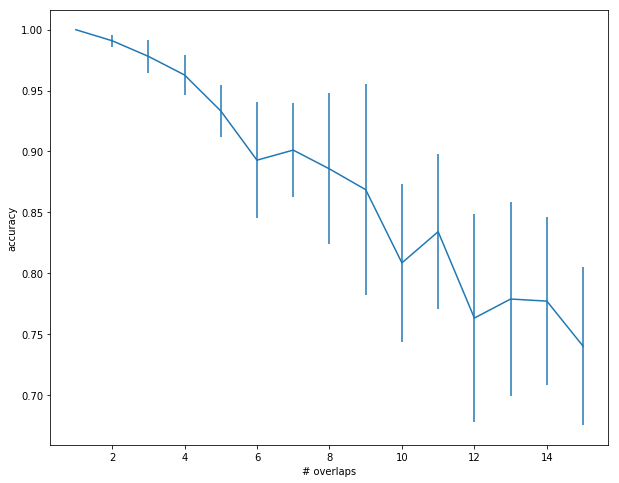

In [11]:
std = np.std(acc, axis=1)
mean = np.mean(acc, axis=1)
plt.figure(figsize=(10,8))
plt.errorbar(np.arange(1,16), mean, yerr=[std, std])
plt.xlabel("# overlaps")
plt.ylabel("accuracy")

In [12]:
np.save("accopt.npy",acc)
np.save("weight.npy",weights)

In [6]:
sess = tf.Session()
train_it0, train_it1 = get_training_iterator(n=0)
sess.run(tf.global_variables_initializer())
sess.run(train_it0.initializer)
sess.run(train_it1.initializer)
images, label = get_batch(n=4, istrain=0)
plt.imshow(sess.run(images)[19,:,:,0].astype(np.uint8))
sess.close()

TypeError: Tensor objects are only iterable when eager execution is enabled. To iterate over this tensor use tf.map_fn.

In [14]:
np.array(weights).shape

(15, 1, 123, 1)